In [1]:
import os
import time
from tqdm.notebook import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
print(torchvision.__version__) # 0.14.1
import torchvision.transforms as transforms
from torchvision.models import resnet34, ResNet34_Weights, resnet18, ResNet18_Weights,\
                                mobilenet_v3_small, MobileNet_V3_Small_Weights



/Users/jameschen/opt/anaconda3/envs/coreml/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.14.0


In [3]:
!pwd

/Users/jameschen/Desktop/16621 MSCV Capstone/Project/pytorch2coreml


## Wrap classifier

In [4]:
class ResNetClassifier(nn.Module):
    def __init__(self, output_dim, which_resnet="resnet34"):
        super(ResNetClassifier, self).__init__()
        if which_resnet == "resnet34":
            #from torchvision.models import resnet34, ResNet34_Weights
            self.model = resnet34(weights=ResNet34_Weights.DEFAULT)
        elif which_resnet == "resnet18":
            #from torchvision.models import resnet18, ResNet18_Weights
            self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        elif which_resnet == "mobilenet_v3_small":
            #from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
            self.model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
        else:
            raise NotImplementedError()

        if "resnet" in which_resnet:
            self.model.fc = nn.Linear(self.model.fc.in_features, output_dim)
        elif "mobilenet" in which_resnet:
            self.model.classifier[3] = nn.Linear(self.model.classifier[3].in_features, output_dim)

    def forward(self, img):    
        return self.model(img)
    
class ResNetClassifierWrapper(nn.Module):
    """
    Wrap ResNetClassifier for convenient coreml use
    
    Changes:
        1. normalize the input
        2. post-process the output logits into argmax ind
    
    Still need other pre-processing:
        1. resize
        2. homography transformation is from OSMO
    """
    def __init__(self, classifier):
        super(ResNetClassifierWrapper, self).__init__()
        self.ResNetClassifier = classifier
#         self.preprocess = transforms.Compose([ # used in test transform
# #             transforms.ToTensor(),
# #             transforms.Resize((256,256), interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         ])
        self.mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).view(3,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).view(3,1,1)
    
    def forward(self, img):  
        """
        img: [1,3,256,256]
        """
#         img = torch.nn.functional.interpolate(img, (256,256))

        img = (img - self.mean)/self.std
        logits =  self.ResNetClassifier(img)#[0]
        return logits #.detach()
    

In [5]:
# torch.load(model_path, map_location=torch.device('cpu')).model

In [9]:
model_path = "pytorch_model_weight/resnet_v2_model.pt"
# model_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Pytorch-CoreML-Skeleton/resnet_OSMO_model"
torch_model = torch.load(model_path, map_location=torch.device('cpu'))
torch_model = ResNetClassifierWrapper(torch_model)
# torch_model

## Run with real img

In [8]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256), interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

sample_input_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/pytorch2coreml/resized_train_data/22_0_ipad_homog_bg2wood_pre/2158.jpg"
# sample_input_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_ipad_homog/5.jpg"
# sample_input_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_ipad_homog/1829.jpg"
sample_img = Image.open(sample_input_path)
sample_img = test_transform(sample_img).unsqueeze(0).to(torch.float32)
# example_input = sample_img
sample_img.shape, sample_img.max(), sample_img.min()

(torch.Size([1, 3, 256, 256]), tensor(0.9796), tensor(0.0762))

In [238]:
# plt.imsave("22_1_ipad_homog_1829_pre.jpg", sample_img[0].numpy())

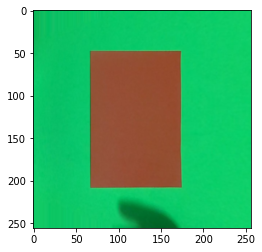

In [201]:
## save pre-processed input img
def untransform(torch_img):
    """
    convert transformed img in tensor to restored numpy array
    """
    img = torch_img.numpy()
    if img.ndim == 4: # assume single img in batch dim
        img = img[0]
    img = img.transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     img = std * img + mean
#     img = np.clip(img, 0, 1)
    return img

sample_img_np = untransform(sample_img)
plt.imshow(sample_img_np)

In [171]:
sample_img_np.shape, sample_img_np.max(), sample_img_np.min()

((256, 256, 3), 0.8212797622680664, 0.0010488537549972476)

In [202]:
plt.imsave("22_1_ipad_homog_5_pre.jpg", sample_img_np)

## Compare torch model with traced_model

In [36]:
optimize_for_mobile = True
# check
torch_model.eval()

example_input = sample_img
# example_input = torch.rand(1, 3, 512, 512)
print(example_input.shape)

torch_out = torch_model(example_input)
# print(torch_out.detach().numpy())
print(torch_out, torch.argmax(torch_out))

## complete disable backward graph or future autograd usage: https://pytorch.org/docs/stable/notes/autograd.html#locally-disable-grad-doc
## use for deployment to get performance gain: https://discuss.pytorch.org/t/does-torch-jit-script-requires-no-grad-and-eval-modes/132181/8
with torch.inference_mode(): 
    traced_model = torch.jit.trace(torch_model, example_input)
    if optimize_for_mobile:
        ## check: https://pytorch.org/docs/1.13/mobile_optimizer.html?highlight=mobile_optimizer
        ## make sure to add useful methods in `preserved_methods`
        import torch.utils.mobile_optimizer as mobile_optimizer        
        mobile_optimizer.optimize_for_mobile(traced_model)
    traced_out = traced_model(example_input)
# print(traced_out.numpy())
print(traced_out, torch.argmax(torch_out))

traced_out.shape, np.allclose(torch_out.detach().numpy(), traced_out.numpy())

torch.Size([1, 3, 256, 256])
tensor([[-1.4787, -2.5231, -0.8638,  0.6339, -0.7802,  5.8496, -2.2926,  2.2494,
         -0.4241, -2.4968, -1.0649]], grad_fn=<AddmmBackward0>) tensor(5)
tensor([[-1.4787, -2.5231, -0.8638,  0.6339, -0.7802,  5.8496, -2.2926,  2.2494,
         -0.4241, -2.4968, -1.0649]]) tensor(5)


(torch.Size([1, 11]), True)

In [37]:
import coremltools as ct

# Using image_input in the inputs parameter:
# Convert to Core ML program using the Unified Conversion API.

# ## TensorType input
# mlmodel = ct.convert(
#     traced_model,
# #     convert_to="mlprogram",
#     inputs=[ct.TensorType(shape=example_input.shape, name='input_image', dtype=np.float32)],
#     outputs=[ct.TensorType(name='output_logits', dtype=np.float32)],
# #     compute_precision=ct.precision.FLOAT32
# )

# ## deploy at mac10.15
# mlmodel = ct.convert(
#     traced_model,
# #     convert_to="mlprogram",
#     inputs=[ct.TensorType(shape=example_input.shape, name='input_image', dtype=np.float32)],
#     outputs=[ct.TensorType(name='output_logits', dtype=np.float32)],
#     minimum_deployment_target=ct.target.macOS10_15
# )

# ## use imagetype input: 
# ## from transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# # scale = [1/(0.229*255.0), 1/(0.224*255.0), 1/(0.225*255.0)]
# scale = 1/(0.226*255.0) # only accept one float/int
# bias = [- 0.485/(0.229) , - 0.456/(0.224), - 0.406/(0.225)]

# image_input = ct.ImageType(name="input_image",
#                            shape=example_input.shape,
#                            scale=scale, bias=bias) # implicitly set channel_first=True to handle permute
# mlmodel = ct.convert(
#     traced_model,
#     inputs=[image_input],
#     outputs=[ct.TensorType(name='output')],
#     compute_units=ct.ComputeUnit.CPU_ONLY
# )

## output logits, and use imagetype input and class_labels as ClassifierConfig: 
image_input = ct.ImageType(name="input_image",shape=example_input.shape,
                          scale=1/255., channel_first=True) # implicitly set channel_first=True to handle permute
#                           scale=1/(0.226*255.0), bias=[-0.485/(0.229), -0.456/(0.224), -0.406/(0.225)]) # implicitly set channel_first=True to handle permute
class_labels = [f"{str(i)}" for i in range(11)]
mlmodel = ct.convert(
    traced_model,
    inputs=[image_input],
    outputs=[ct.TensorType(name='output', dtype=np.float32)],
    classifier_config = ct.ClassifierConfig(class_labels),
    compute_units=ct.ComputeUnit.CPU_ONLY
)



Converting PyTorch Frontend ==> MIL Ops:  99%|▉| 168/169 [00:00<00:00, 1715.69 o
Running MIL Clean up passes: 100%|████████| 11/11 [00:00<00:00, 146.15 passes/s]
Translating MIL ==> NeuralNetwork Ops: 100%|█| 184/184 [00:01<00:00, 180.93 ops/


In [290]:
# mlmodel

In [40]:
mlmodel.save("optized_origami_resnet_v2.mlmodel")

In [11]:
## np input
results = mlmodel.predict({"input_image": example_input.numpy()})
ml_result = results['output_logits'][0]
ml_result

In [20]:
torch_out.shape, torch_out

(torch.Size([1, 11]),
 tensor([[ 0.3024, -0.0332, -0.8061, -0.2054, -0.2826, -0.5159, -0.0212, -0.4186,
          -0.0606, -1.0474,  1.1727]], grad_fn=<AddmmBackward0>))

In [22]:
np.allclose(torch_out.detach().numpy()[0], ml_result)

False

In [12]:
# Print input description to get input shape.
display(mlmodel.get_spec().description.input)

display(mlmodel.get_spec().description.output)

[name: "input_image"
type {
  imageType {
    width: 256
    height: 256
    colorSpace: RGB
  }
}
]

[name: "output"
type {
  dictionaryType {
    stringKeyType {
    }
  }
}
, name: "classLabel"
type {
  stringType {
  }
}
]

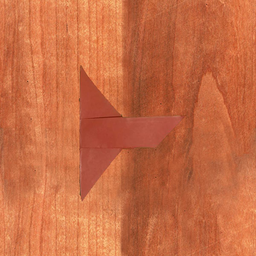

In [38]:
# sample_input_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/new_test/2.jpg"
img = Image.open(sample_input_path)
img = img.resize([256, 256], Image.LANCZOS)
img # [0~255]

In [39]:
# Make a prediction with the Core ML version of the model.
# Get the output name automatically from protobuf spec of the model.
spec = mlmodel.get_spec()
for out in spec.description.output:
    if out.type.WhichOneof('Type') == "dictionaryType":
        coreml_dict_name = out.name
        break
        
coreml_out_dict = mlmodel.predict({"input_image" : img})
print("coreml predictions: ")
print("top class label: ", coreml_out_dict["classLabel"])

coreml_prob_dict = coreml_out_dict[coreml_dict_name]
coreml_prob_dict

coreml predictions: 
top class label:  State 5


{'State 0': -1.5655614137649536,
 'State 1': -2.5543272495269775,
 'State 10': -0.9667754173278809,
 'State 2': -0.8961889147758484,
 'State 3': 0.7876850366592407,
 'State 4': -0.9074714183807373,
 'State 5': 5.7186279296875,
 'State 6': -2.201007843017578,
 'State 7': 2.3212664127349854,
 'State 8': -0.39858561754226685,
 'State 9': -2.4290430545806885}

In [15]:
coreml_result = [ coreml_prob_dict[f"State {i}"] for i in range(11)]
coreml_result

[-1.5655614137649536,
 -2.5543272495269775,
 -0.8961889147758484,
 0.7876850366592407,
 -0.9074714183807373,
 5.7186279296875,
 -2.201007843017578,
 2.3212664127349854,
 -0.39858561754226685,
 -2.4290430545806885,
 -0.9667754173278809]

In [19]:
display(torch_out.detach().numpy())

np.allclose(torch_out.detach().numpy(), coreml_result)

array([[-1.4787009 , -2.5230722 , -0.8638319 ,  0.6339197 , -0.7802414 ,
         5.8496056 , -2.2925515 ,  2.2493613 , -0.42409545, -2.4967835 ,
        -1.0648986 ]], dtype=float32)

False

In [20]:
display(list( zip(torch_out.detach().numpy().tolist()[0], coreml_result) ))

[(-1.478700876235962, -1.5655614137649536),
 (-2.5230722427368164, -2.5543272495269775),
 (-0.8638318777084351, -0.8961889147758484),
 (0.6339197158813477, 0.7876850366592407),
 (-0.7802413702011108, -0.9074714183807373),
 (5.849605560302734, 5.7186279296875),
 (-2.2925515174865723, -2.201007843017578),
 (2.249361276626587, 2.3212664127349854),
 (-0.4240954518318176, -0.39858561754226685),
 (-2.496783494949341, -2.4290430545806885),
 (-1.0648986101150513, -0.9667754173278809)]

In [231]:
img = Image.open(sample_input_path) # 0~255
img = img.resize([256, 256], Image.LANCZOS) 
coreml_out_dict = mlmodel.predict({"input_image" : img})
coreml_out_dict

{'classLabel': 'State 1',
 'output': {'State 0': 0.1652122586965561,
  'State 1': 6.62412691116333,
  'State 10': -3.120645523071289,
  'State 2': 0.509382426738739,
  'State 3': 1.1159546375274658,
  'State 4': 2.2639825344085693,
  'State 5': -0.6026735305786133,
  'State 6': -4.4883575439453125,
  'State 7': -2.4473931789398193,
  'State 8': -1.999472975730896,
  'State 9': -1.8958460092544556}}

## Preprocess batch images
resize + scale

In [224]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256), interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# sample_input_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_ipad_homog/5.jpg"
# sample_input_path = "/Users/jameschen/Desktop/16621 MSCV Capstone/Project/Code/data/22_1_ipad_homog/1829.jpg"
for sample_input_path in glob.glob("/Users/jameschen/Desktop/16621 MSCV Capstone/Pytorch-CoreML-Skeleton/python/saved_data/22_0_ipad_homog_bg2wood_pre/*.jpg"):
    sample_img = Image.open(sample_input_path)
    sample_img = test_transform(sample_img).to(torch.float32)
    sample_img_np = sample_img.numpy().transpose((1, 2, 0))
    plt.imsave(os.path.join(os.path.dirname(sample_input_path), "preprocess", os.path.basename(sample_input_path)) , sample_img_np)
    

In [220]:
glob.glob("/Users/jameschen/Desktop/16621 MSCV Capstone/Pytorch-CoreML-Skeleton/python/saved_data/22_0_ipad_homog_bg2wood_pre/*.jpg")

['/Users/jameschen/Desktop/16621 MSCV Capstone/Pytorch-CoreML-Skeleton/python/saved_data/22_0_ipad_homog_bg2wood_pre/374.jpg',
 '/Users/jameschen/Desktop/16621 MSCV Capstone/Pytorch-CoreML-Skeleton/python/saved_data/22_0_ipad_homog_bg2wood_pre/982.jpg',
 '/Users/jameschen/Desktop/16621 MSCV Capstone/Pytorch-CoreML-Skeleton/python/saved_data/22_0_ipad_homog_bg2wood_pre/2893.jpg',
 '/Users/jameschen/Desktop/16621 MSCV Capstone/Pytorch-CoreML-Skeleton/python/saved_data/22_0_ipad_homog_bg2wood_pre/3233.jpg',
 '/Users/jameschen/Desktop/16621 MSCV Capstone/Pytorch-CoreML-Skeleton/python/saved_data/22_0_ipad_homog_bg2wood_pre/3043.jpg',
 '/Users/jameschen/Desktop/16621 MSCV Capstone/Pytorch-CoreML-Skeleton/python/saved_data/22_0_ipad_homog_bg2wood_pre/2158.jpg',
 '/Users/jameschen/Desktop/16621 MSCV Capstone/Pytorch-CoreML-Skeleton/python/saved_data/22_0_ipad_homog_bg2wood_pre/2588.jpg',
 '/Users/jameschen/Desktop/16621 MSCV Capstone/Pytorch-CoreML-Skeleton/python/saved_data/22_0_ipad_homog_b

In [215]:
os.path.basename('/Users/jameschen/Desktop/22_1_ipad_homog_pre/1482.jpg')

'1482.jpg'

In [223]:
os.path.dirname('/Users/jameschen/Desktop/22_1_ipad_homog_pre/1482.jpg')

'/Users/jameschen/Desktop/22_1_ipad_homog_pre'